In [1]:
from __future__ import print_function
import PIL
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import text
from IPython.display import display, Math, Latex, Markdown
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstatsπ
from tqdm.notebook import tqdm
import random

from scipy import stats, interpolate
from astropy.visualization import hist

import emcee
import corner

## Samples with MCMC
for reference https://emcee.readthedocs.io/en/stable/user/sampler/

I have a bounch of data from a transient event and I want to know the distribution of the parameters that best describe my data, given the model I am hypotizing. 

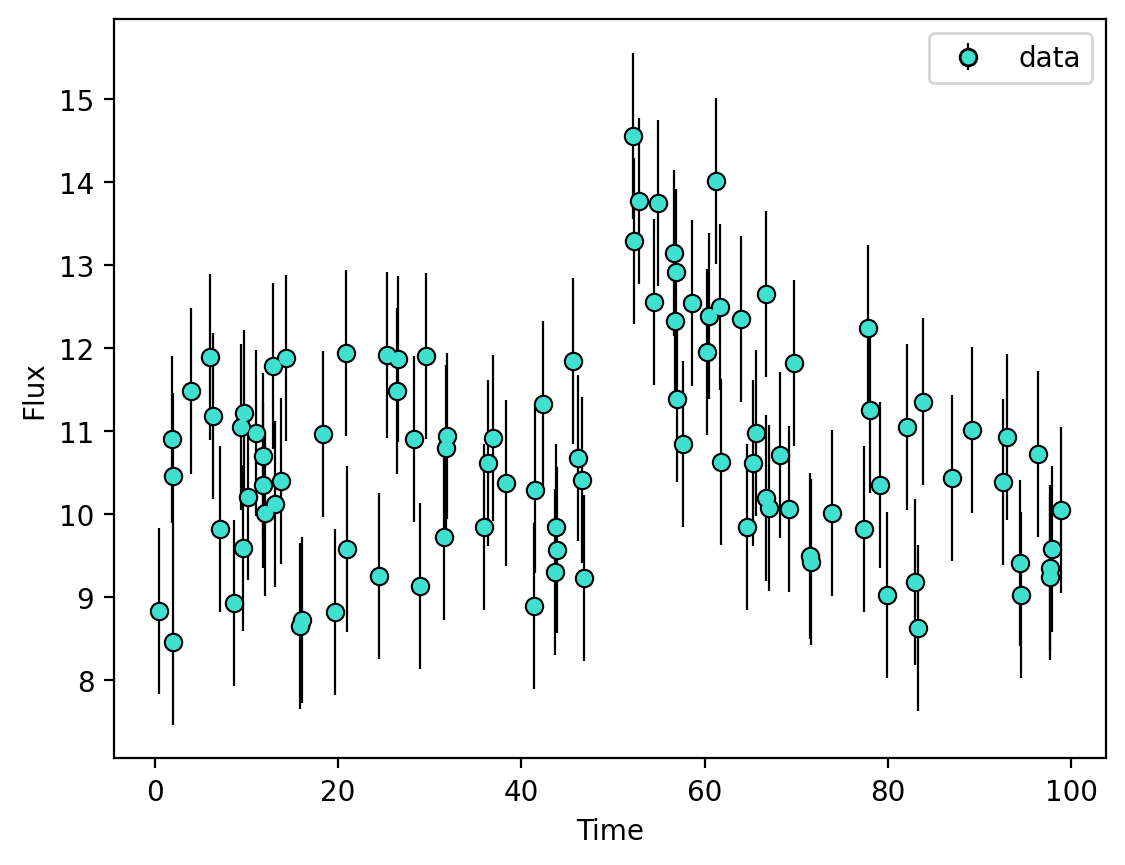

In [2]:
data = np.load("./transient.npy")
time = data[:,0]
flux = data[:,1]
err_f = data[:,2]

plt.errorbar(time, flux, yerr=err_f, fmt="o", ms=6, mec="black", ecolor='black', mfc='turquoise',
             elinewidth=0.8, label='data', zorder=0)
plt.scatter(time,flux,color='turquoise',s=20,alpha=1,edgecolors='turquoise', zorder=1)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

## Prior on the parameters
Let's do an hypotesis on the model:

$ y =  \begin{cases}
b \text{ for $t<t_0$ }\\
b + A\exp[-\alpha(t-t_0)] \text{ for $t\geq t_0$ } \\
\end{cases}$

Let's hypotize some guesses on the parameters:

$\begin{cases}
b = \bar{y} \longrightarrow \text{mean flux} \\
A = max(y) - b \longrightarrow \text{amplitude=diff(max-mean)} \\
t_0 = t | max(y(t)) \longrightarrow \text{time at which the flux has a maximum} \\
\alpha = 0.1
\end{cases}
$

And so the prior on the parameter is that they are drawn from uniform distributions, i.e. for $b,A,t_0 \in [par_{guess} - 20, par_{guess} +20]$, and for $\alpha \in [-0.5,0.5]$

$\Longrightarrow prior =  
\begin{cases}
1 \text{   if parameters are chosen inside the uniform distrib} \\
0 \text{   elsewhere}
\end{cases}$

## Likelihood

Assume a gaussian likelihood for the model given the data:

$$L = \text{exp} \bigg\{ -\frac{1}{2} \frac{(y-model(A,b,t_0,\alpha))^2}{\sigma_y ^2} \bigg\}$$

## Posterior

Is simply the un-normalized product between the prior and the likelihood:

$$posterior = L*prior $$

In [3]:
b_guess = np.mean(flux[:50])
a_guess = np.max(flux) - b_guess
t0_guess = np.argmax(flux)
alpha_guess = 0.1
print("Initial guess on a: ", a_guess, "\nInitial guess on b: ", b_guess, 
      "\nInitial guess on t0: ", t0_guess, "\nInitial guess on alpha: ", alpha_guess)

Initial guess on a:  4.139771922609251 
Initial guess on b:  10.418162108915366 
Initial guess on t0:  51 
Initial guess on alpha:  0.1


In [4]:
#define the model
def sharp_burst(x, a, b, t0, alpha):
    y = []
    for i in range(0, len(x)):
        if x[i] < t0:
            y.append(b)
        elif x[i] >= t0:
            y.append(b + a*np.exp(-alpha*(x[i] - t0)))
    return y

#define the loglikelihood
def like(prob, time, flux, err_flux):
    a, b, t0, alpha = prob
    return np.prod(np.exp(-1/2*(flux-sharp_burst(time,a,b,t0,alpha)/err_flux)**2))

#define the prior
def prior(prob):
    a, b, t0, alpha = prob
    if a_guess - 20 < a < a_guess + 20 and b_guess - 20 < b < b_guess + 20 and t0_guess - 10 < t0 < t0_guess + 10 and -0.5 < alpha < 0.5:
        return 1
    return 0

#define posterior
def logposterior(prob, time, flux, err_flux):
    return np.log(like(prob, time, flux, err_flux)*prior(prob))

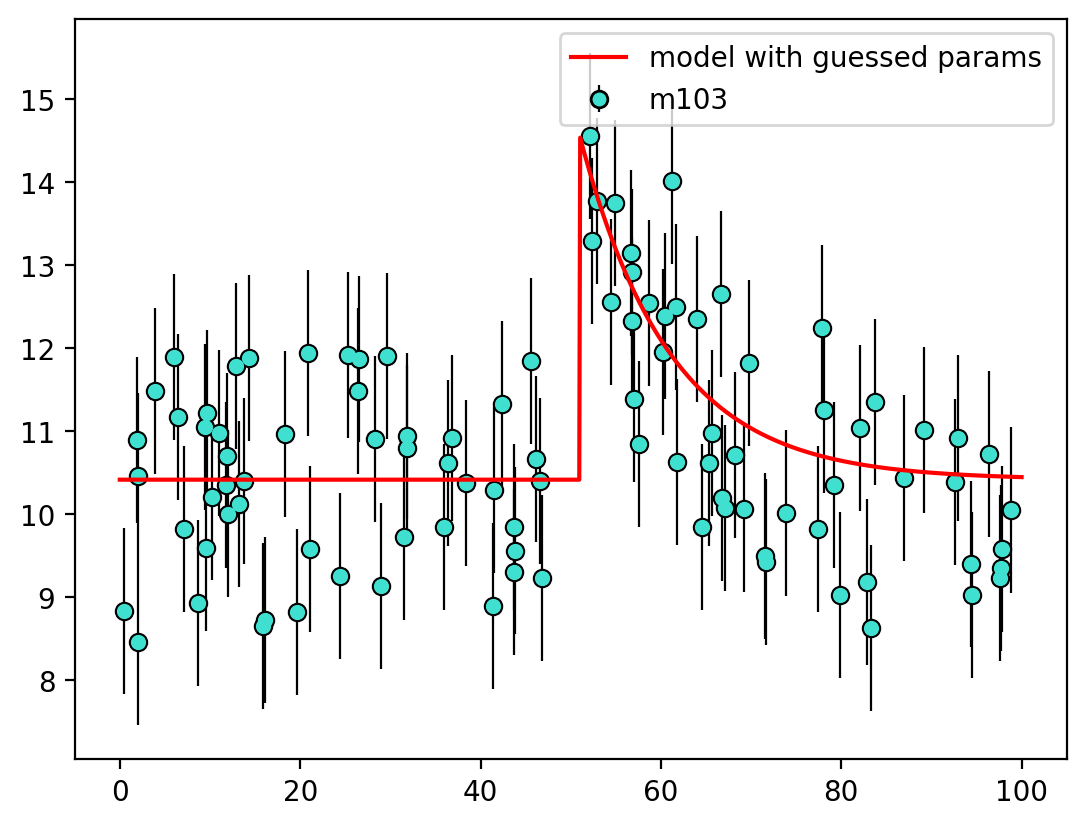

In [5]:
xgrid = np.linspace(0,100,1000)
y = sharp_burst(xgrid, a=a_guess, b=b_guess, t0=t0_guess,alpha=alpha_guess)

plt.errorbar(time, flux, yerr=err_f, fmt="o", ms=6, mec="black", ecolor='black', mfc='turquoise',
             elinewidth=0.8, label='m103', zorder=0)
plt.scatter(time,flux,color='turquoise',s=20,alpha=1,edgecolors='turquoise', zorder=1)
plt.plot(xgrid, y, 'r', label="model with guessed params" )
plt.legend()
plt.show()

## MCMC
Now let's run a MCMC to find the distribution of our 4 parameters.\
I want 8 walkers to explore the parameter space with 5000 draws and burn in of 1000 to let the chain stabilize.

I also want to check that the chain is well exploring all the parameter space and does not get stuck 

In [6]:
ndim = 4  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))*1e-2+np.array([a_guess, b_guess, t0_guess, alpha_guess])

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[time, flux, err_f])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)
flat_trace = emcee_trace.flatten()

print("done")
print(starting_guesses)

/tmp/ipykernel_7287/2855329542.py:25: RuntimeWarning: divide by zero encountered in log
  return np.log(like(prob, time, flux, err_flux)*prior(prob))


done
[[ 4.14526006 10.425314   51.00602763  0.10544883]
 [ 4.14400847 10.42462105 51.00437587  0.10891773]
 [ 4.14940855 10.42199652 51.00791725  0.10528895]
 [ 4.14545237 10.42741808 51.00071036  0.10087129]
 [ 4.13997411 10.42648831 51.00778157  0.10870012]
 [ 4.14955811 10.42615369 51.00461479  0.10780529]
 [ 4.14095467 10.42456132 51.00143353  0.10944669]
 [ 4.14499041 10.42230873 51.00264556  0.10774234]]


In [7]:
tau = sampler.get_autocorr_time()
print(tau)

[90.33618633 46.98932655 73.5459749  77.55295439]


In [8]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain 
print(flat_trace.shape)
print(xgrid.shape)
print(np.mean(emcee_trace[:1,0]))

(8, 5000, 4)
(32000, 4)
(128000,)
(1000,)
5.208685870926385


Text(0.5, 0, 'step number')

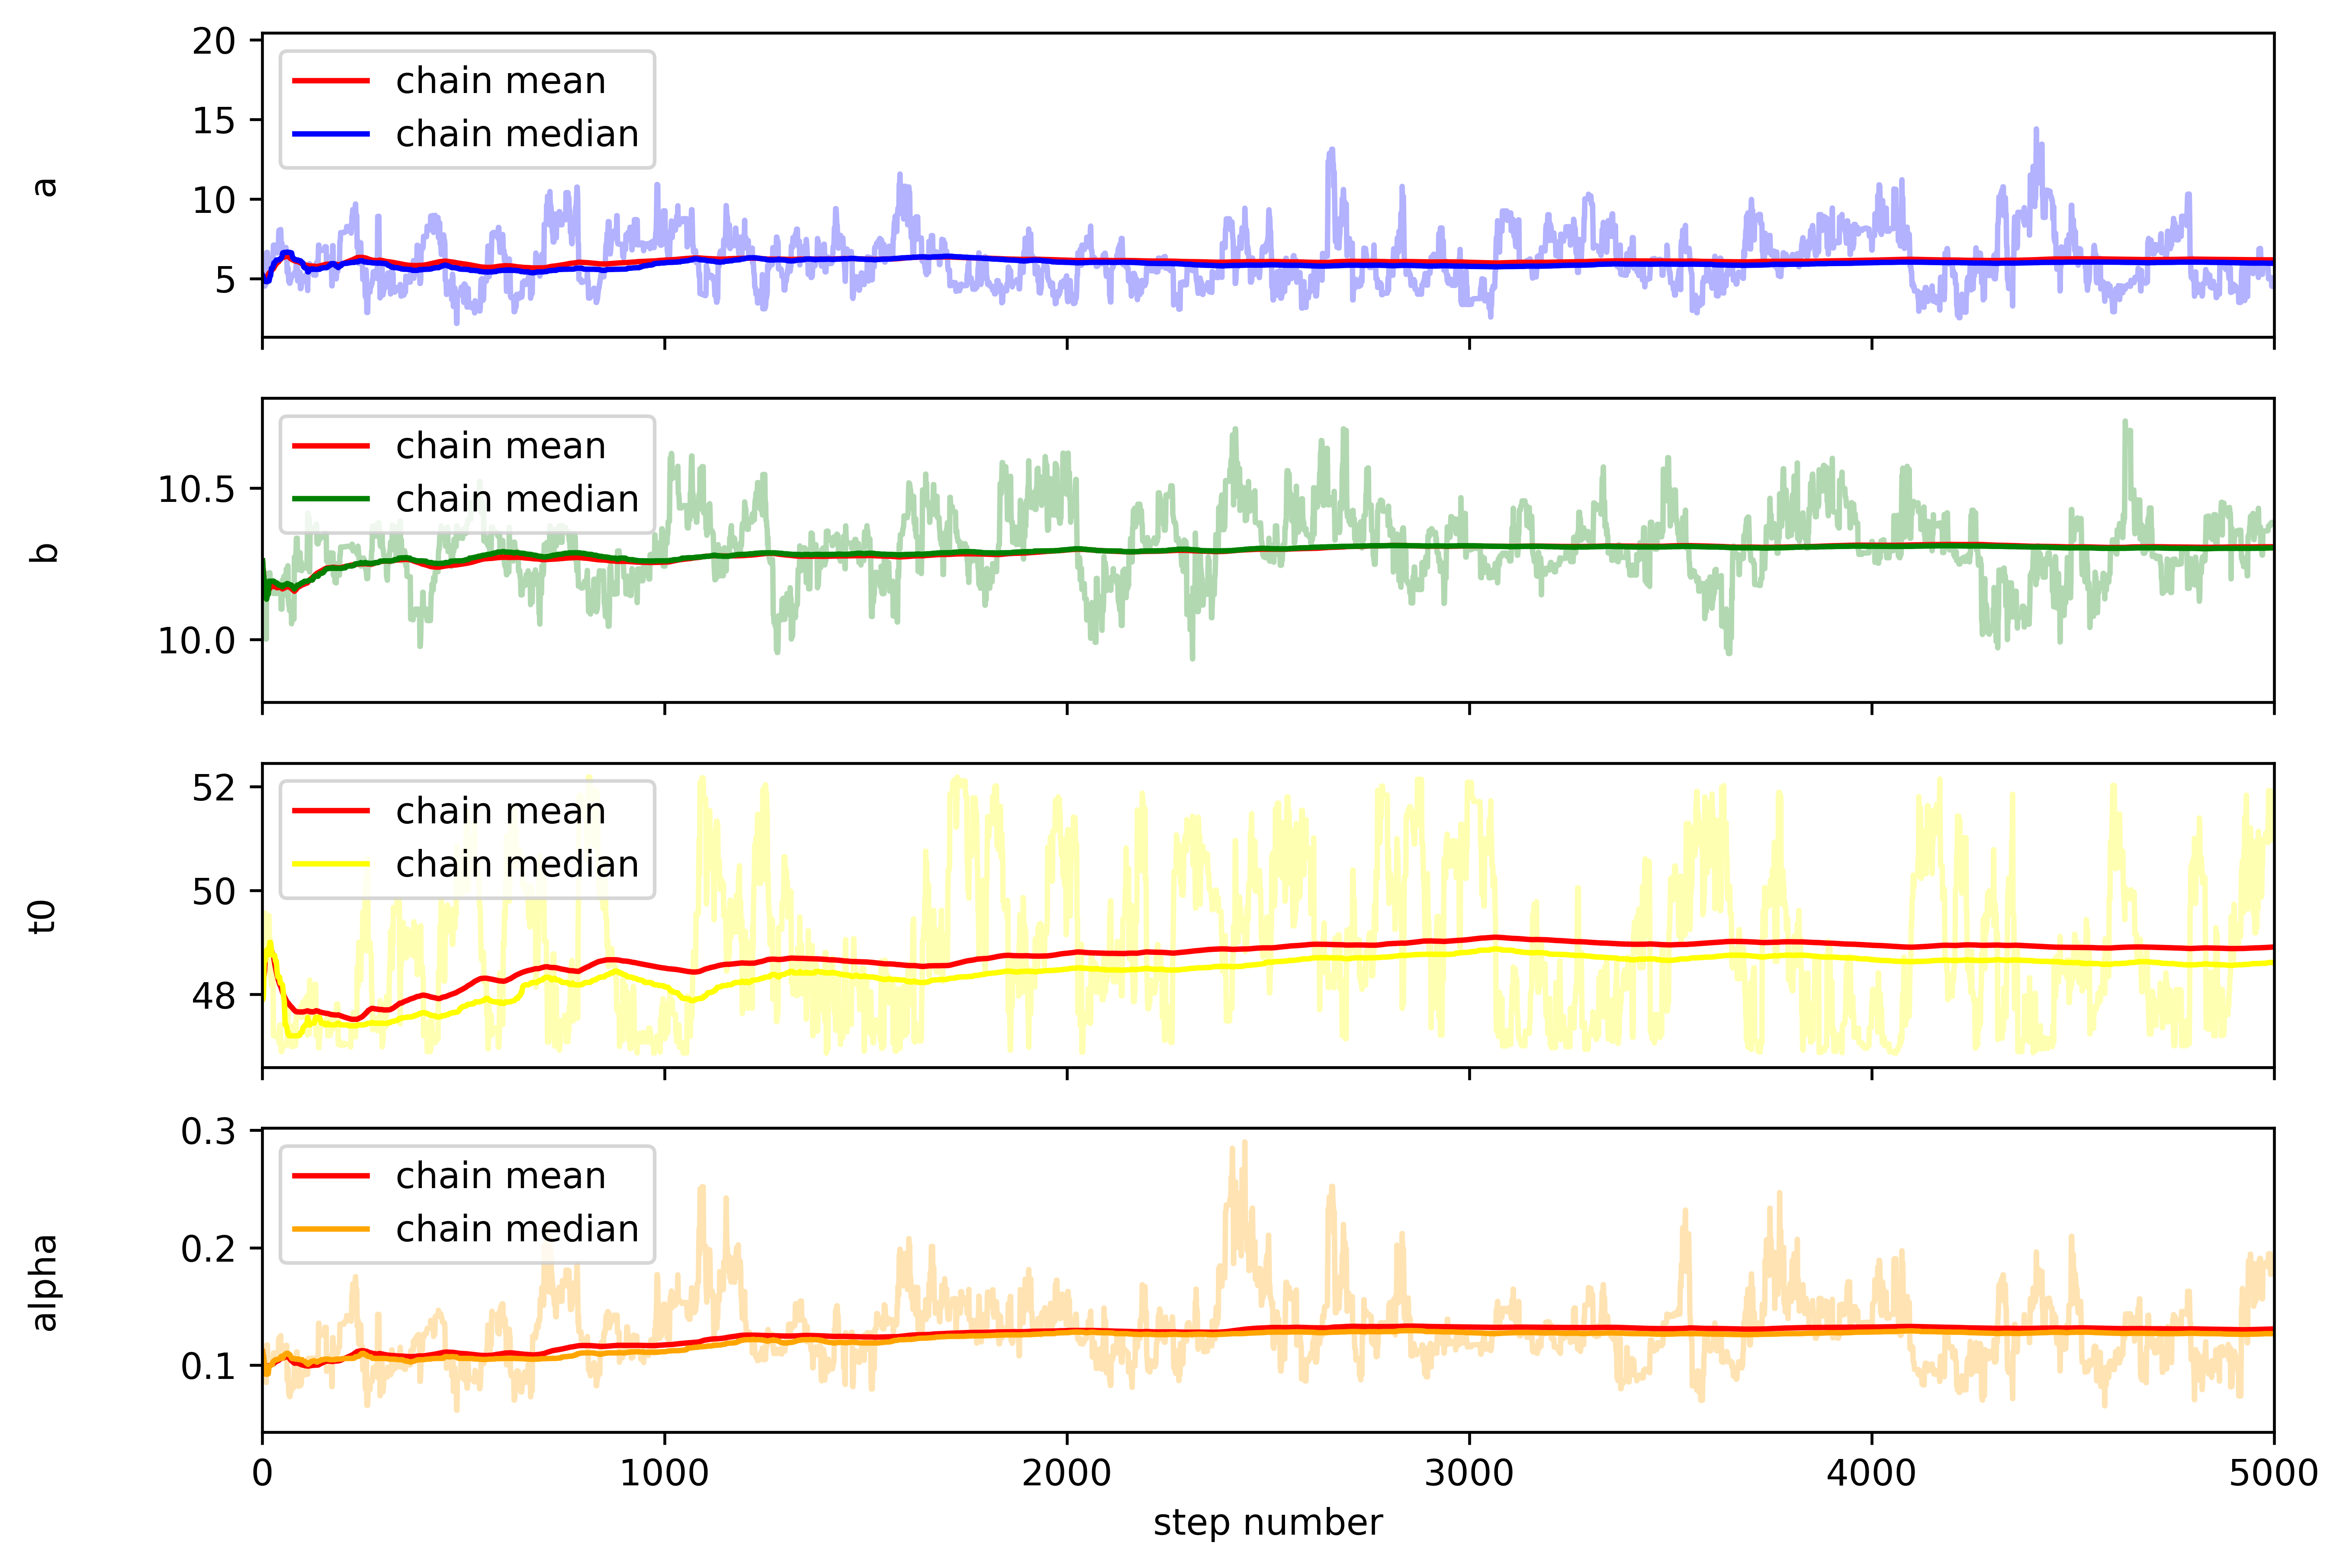

In [9]:
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 300
rcParams["font.size"] = 10

#plot 
xgrid1 = np.linspace(1, nsteps, nsteps)
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
colors = ["blue", "green", "yellow", "orange"]
labels = ["a", "b", "t0", "alpha"]
meanC = []
median = []

for i in range(ndim):
                
    # plot running mean: 
    meanC_i = [np.mean(emcee_trace[:int(N),i]) for N in xgrid1]
    medianC_i = [np.median(emcee_trace[:int(N),i]) for N in xgrid1]
    meanC.append(meanC_i[nsteps-1])
    median.append(medianC_i[nsteps-1])
    
    ax = axes[i]
    ax.plot(emcee_trace[:,i], color=colors[i], alpha=0.3)
    ax.plot(xgrid1, meanC_i, c='red', label='chain mean')
    ax.plot(xgrid1, medianC_i, c=colors[i], label='chain median') 
    #ax.plot(xgrid, 0*xgrid + np.mean(data), c='yellow',label='data mean')
    ax.set_xlim(0, nsteps)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.legend(fontsize=10)

axes[-1].set_xlabel("step number")

## Corner plots 

To better visualize the distribution of the parameters found by MCMC let's plot a corner plot of the marginalized prob with 68%, 95% and 99% credible region levels. On top of each plot is possible to read the median param and its upper/lower erros.\
In particular, for the 90% credible regions, the parameters are:

$\begin{cases}
A = 5.59_{-1.58}^{+2.82} \\
b = 10.30_{-0.15}^{+0.15} \\
t_0 = 48.98_{-1.72}^{+2.40} \\
\alpha = 0.13_{-0.03}^{+0.05} \\
\end{cases}$

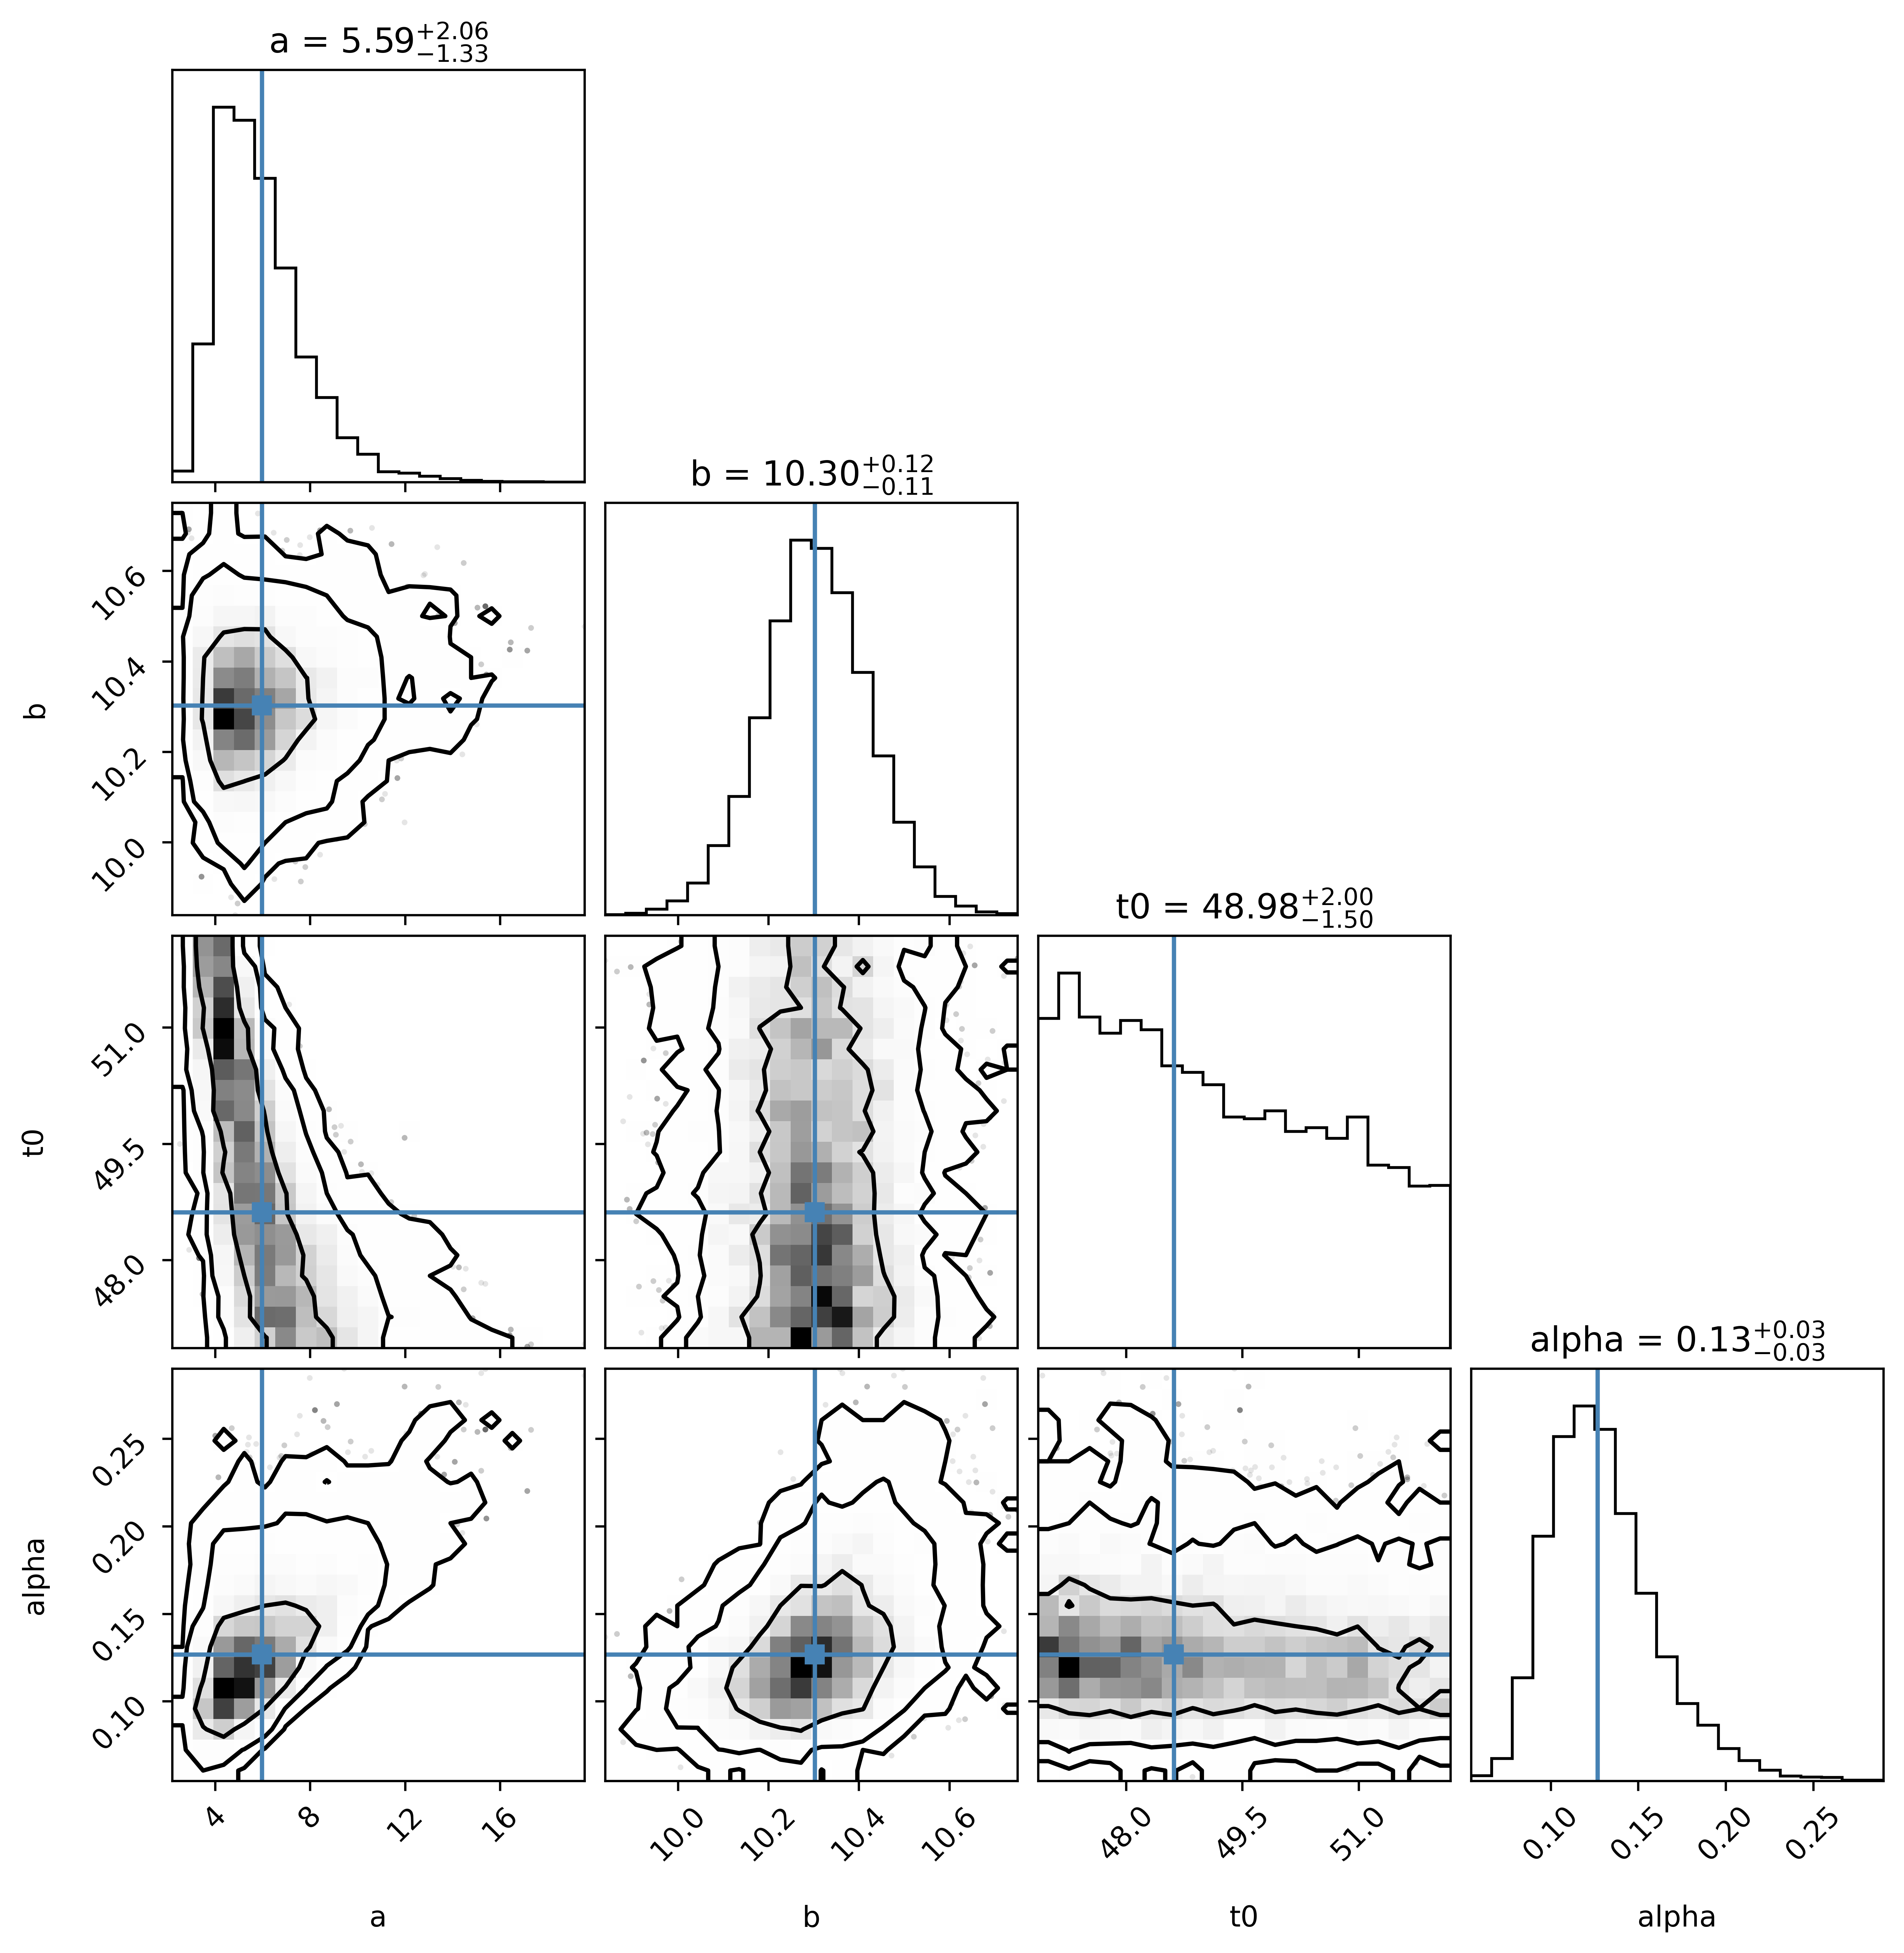

In [10]:
fig = corner.corner(
    emcee_trace, labels=labels, levels=[0.683, 0.955, 0.997], truths=median, show_titles=True) #0.5 quantile

In [11]:
results = np.zeros((4,3))

for i in range(ndim): # must be done once per variable
    q_1, q_50, q_9 = corner.quantile(emcee_trace[:,i], [0.1, 0.5, 0.9]) # your x is q_50
    dx_down, dx_up = q_50-q_1, q_9-q_50
    results[i,0] = q_50
    results[i,1] = dx_down
    results[i,2] = dx_up

In [12]:
results

array([[5.59439577e+00, 1.58356950e+00, 2.82018736e+00],
       [1.03048993e+01, 1.48452047e-01, 1.51220972e-01],
       [4.89802901e+01, 1.72438738e+00, 2.40429967e+00],
       [1.26028375e-01, 3.10231442e-02, 4.47777583e-02]])

## Models distribution

Let's plot the distribution of 100 models with the parameters extracted from their distribution we have found before

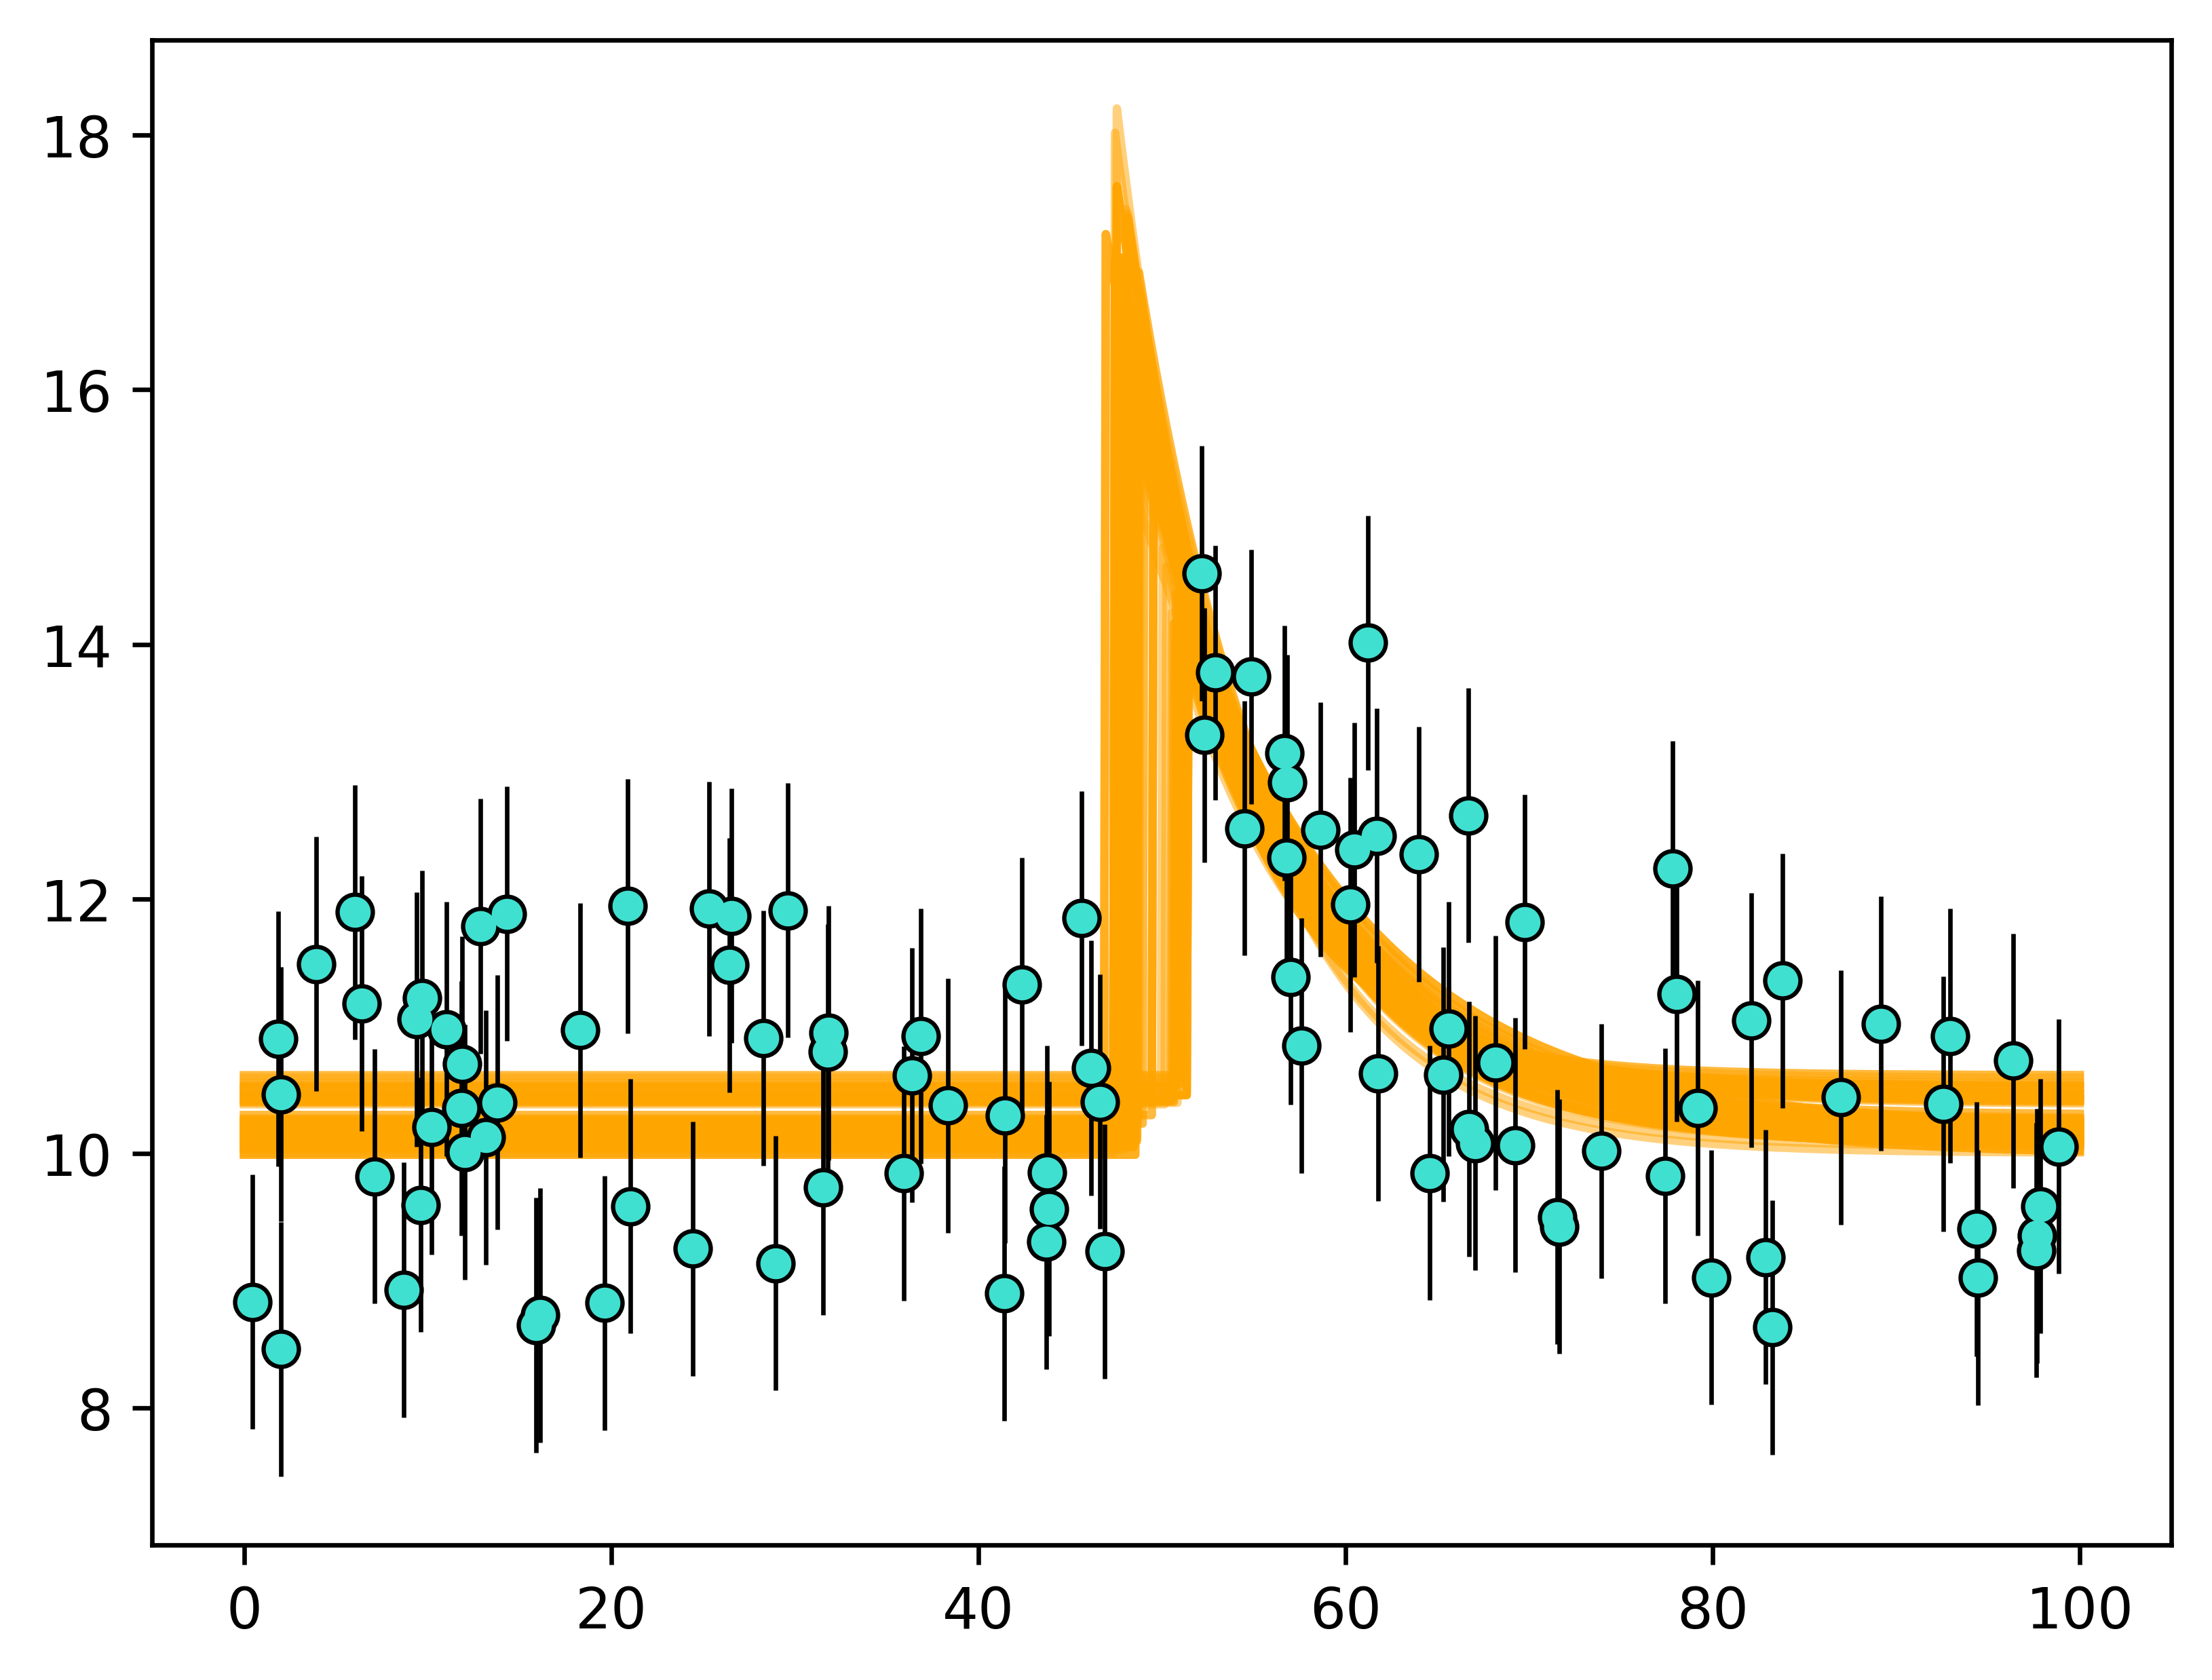

In [13]:
#plot 100 samples with the distrib of parameters found

a_i = emcee_trace[:,0]
b_i = emcee_trace[:,1]
t0_i = emcee_trace[:,2]
alpha_i = emcee_trace[:,3]

for i in range(0, 100):
    y_predictions = sharp_burst(xgrid, a_i[2000+i], b_i[2000+i], t0_i[2000+i], alpha_i[2000+i])
    plt.plot(xgrid, y_predictions, 'orange', alpha=0.5, zorder=0)
plt.errorbar(time, flux, yerr=err_f, fmt="o", ms=6, mec="black", ecolor='black', elinewidth=0.8, label='m103', zorder=1)
plt.scatter(time,flux,color='turquoise',s=20,alpha=1,edgecolors='turquoise', zorder=2)
plt.show()

## Let's see what happens if I add one more "missing value"

I should see that the bounch of models that survive are the ones that already accounted for a value in that "missing" position. All the models with lower amplitude at that point disappear.

Now 90% credible region parameters are

$\begin{cases}
A = 7.36_{-1.63}^{+2.58} \\
b = 10.32_{-0.15}^{+0.15} \\
t_0 = 48.83_{-1.17}^{+1.33} \\
\alpha = 0.15_{-0.03}^{+0.04} \\
\end{cases}$

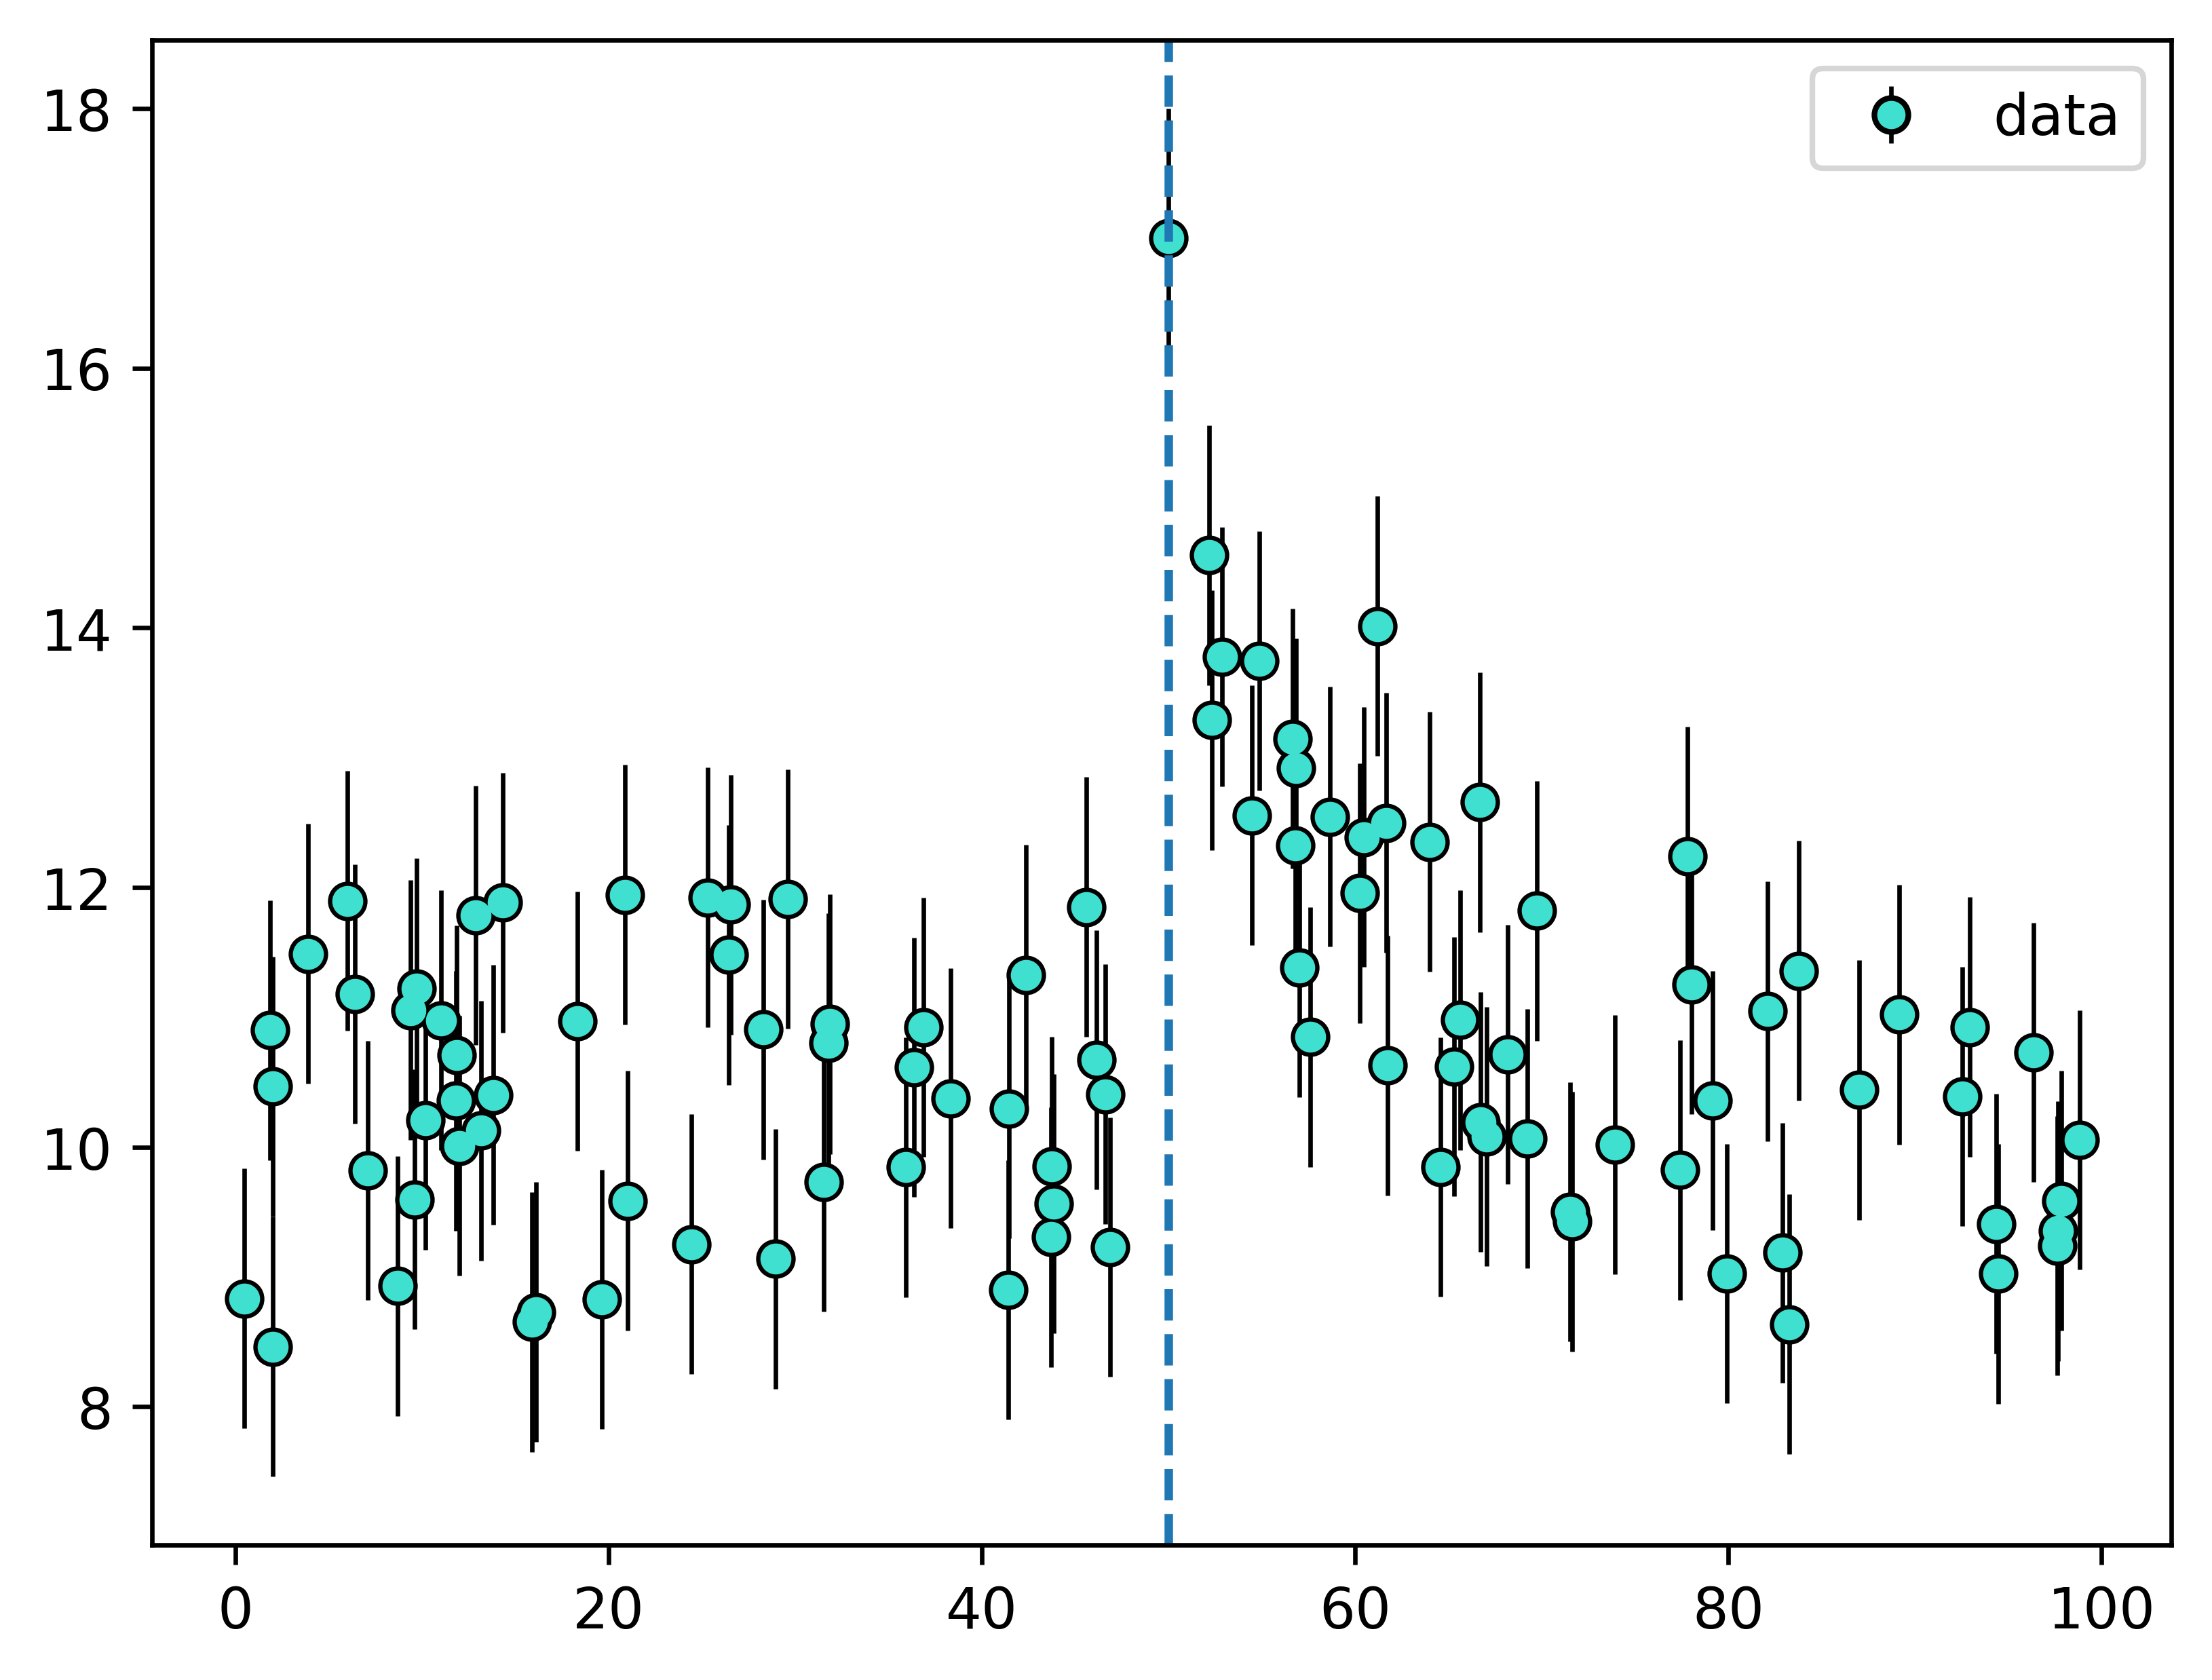

In [14]:
time = np.insert(time, 51, 50)
flux = np.insert(flux, 51, 17)
err_f = np.insert(err_f,51, 1)
#print(time)

plt.errorbar(time, flux, yerr=err_f, fmt="o", ms=6, mec="black", ecolor='black', mfc='turquoise', elinewidth=0.8, label='data', zorder=0)
plt.scatter(time,flux,color='turquoise',s=20,alpha=1,edgecolors='turquoise', zorder=1)
plt.axvline(50, linestyle="dashed")
plt.legend()
plt.show()

In [15]:
# the function call where all the work happens: 
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[time, flux, err_f])
sampler1.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace1  = sampler1.chain[:, burn:, :].reshape(-1, ndim)
flat_trace1 = emcee_trace1.flatten()

print("done")

/tmp/ipykernel_7287/2855329542.py:25: RuntimeWarning: divide by zero encountered in log
  return np.log(like(prob, time, flux, err_flux)*prior(prob))


done


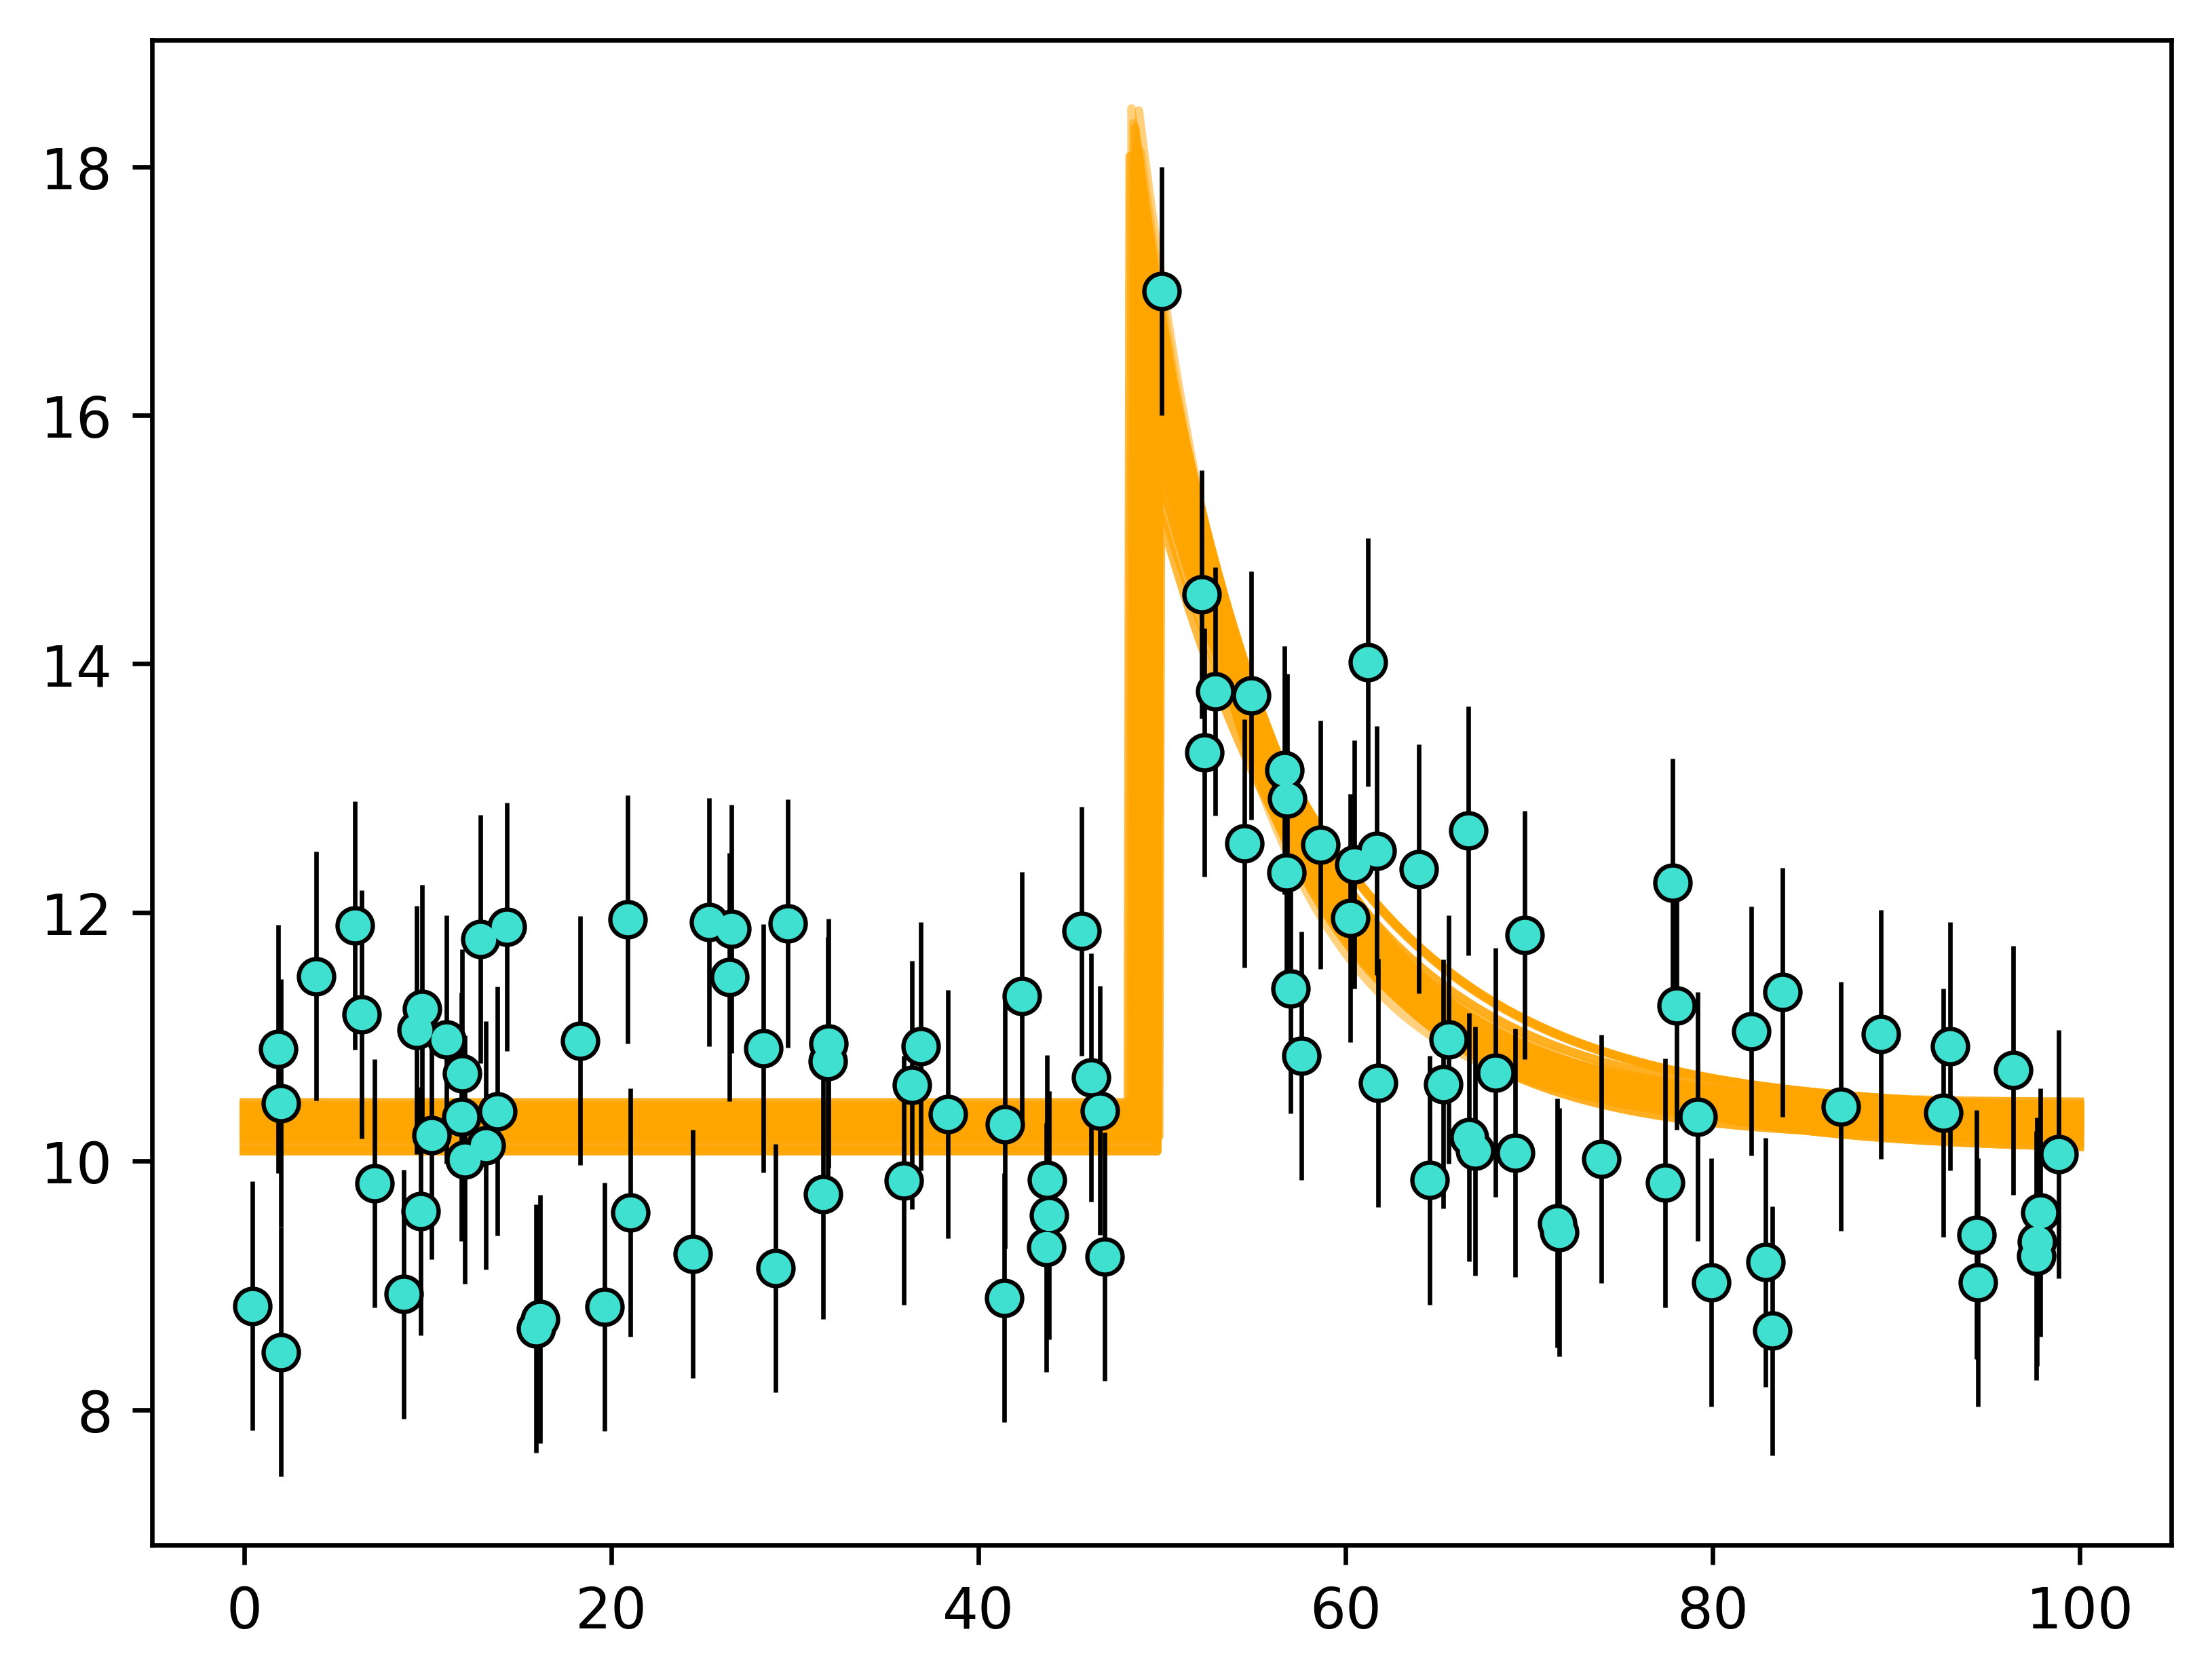

In [16]:
#plot 100 samples with the distrib of parameters found

a_i1 = emcee_trace1[:,0]
b_i1 = emcee_trace1[:,1]
t0_i1 = emcee_trace1[:,2]
alpha_i1 = emcee_trace1[:,3]

for i in range(0, 100):
    y_predictions1 = sharp_burst(xgrid, a_i1[2000+i], b_i1[2000+i], t0_i1[2000+i], alpha_i1[2000+i])
    plt.plot(xgrid, y_predictions1, 'orange', alpha=0.5, zorder=0)
plt.errorbar(time, flux, yerr=err_f, fmt="o", ms=6, mec="black", ecolor='black', elinewidth=0.8, label='m103', zorder=1)
plt.scatter(time,flux,color='turquoise',s=20,alpha=1,edgecolors='turquoise', zorder=2)
plt.show()

In [17]:
results1 = np.zeros((4,3))

for i in range(ndim): # must be done once per variable
    q_1, q_50, q_9 = corner.quantile(emcee_trace1[:,i], [0.1, 0.5, 0.9]) # your x is q_50
    dx_down, dx_up = q_50-q_1, q_9-q_50
    results1[i,0] = q_50
    results1[i,1] = dx_down
    results1[i,2] = dx_up
print(results1)

[[7.36872351e+00 1.63327835e+00 2.58125469e+00]
 [1.03184339e+01 1.50472960e-01 1.54438409e-01]
 [4.83233268e+01 1.16900875e+00 1.32921726e+00]
 [1.47188521e-01 3.21396558e-02 4.03533024e-02]]
